`Cortix` Updated: **24Nov2024** Valmor F. de Almeida

# Design of a Balance of Plant System with Dynamic Networks
> Nikolaus Kemper, Jack Kennedy and Valmor F. de Almeida <br>
> *nikolaus\_kemper@student.uml.edu, jack_kennedy@student.uml.edu and valmor\_dealmeida@uml.edu*<br>
>
> **University of Massachusetts Lowell** <br>
> Dept. of Chemical Engineering, Nuclear Energy Program, Lowell, MA, 01854, <br>
>
> **[SciPy 2021 Virtual Conference](https://www.scipy2021.scipy.org/) ([Poster Session](https://www.scipy2021.scipy.org/posters))**<br>
> July 14-16, 2021 <br>
> Austin, TX (online)
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvec}{\boldsymbol{u}}
  \newcommand{\pvec}{\boldsymbol{p}}
  \newcommand{\qvec}{\boldsymbol{q}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\Fvar}{\boldsymbol{F}}
  \newcommand{\Gvar}{\boldsymbol{G}}
  \newcommand{\Hvar}{\boldsymbol{H}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \newcommand{\Power}{\mathcal{P}}
$

---
### <center> Bringing high-performance, system-level, dynamic modeling and simulation to the Python ecosystem: </center>
### <center> "*How to get there without Simulink while scaling to high-perfomance computing platforms*" </center>
---

<center> 
<img width="600" src="figs/network.png" title="Plant Layout">
<p style="text-align:center;"><b>Balance of plant network graph (SMPWR: Small Modular Pressurized Water Reactor).</b></p> 
</center>

---
## Summary<a id="summary"></a>
We created an extended Balance of Plant (BoP) simulation network using the [`Cortix`](https://cortix.org) Python library. The BoP system was made by connecting multiple `Cortix` modules that modeled unit operations (such as steam
generators, turbines, water heaters, *etc.*) as a networked system. Modules were connected via `Cortix` *ports* that are designated to either
send or receive parallel, message-passing information from other modules. The information exchanged consisted of data
structures representing either flowing water streams that contained temperature, pressure, and flowrate data or energy
streams that transferred energy. Simulations of start up, steady state, shutdown and step change conditions were
performed. Message passing methods in `Cortix` are internally delegated to either `mpi4py` or Python `multiprocessing` libraries.

---

+ The next cells in this Jupyter notebook give details on this work.
+ **Execute this poster on `Binder` by following this [link](https://github.com/dpploy/scipy-2021)** (click on *`launch|binder`*).

## Table of Contents <a id="toc"></a>
| | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| [1. Abstract](#abstract) | [2. Framework](#framework) | [3. Divide and Couple](#divide_couple) | [4. Commonality](#commonality) | [5. Cortix Module](#cortix_module) | [6. Time Evolution](#time_evolution) | [7. Network Assembly](#network_assy) | [6. Ports](#ports) | [7. Problem Statement](#problem) | [8. Module Template](#module_template) |
| [9. Reactor](#reactor) | [10. Steam Generator](#steam_generator) | [11. Turbine](#turbine) | [12. Condenser](#condenser) | [13. Water Heater](#water_heater) | [14. Startup](#startup) | [15. Steady State](#steady_state) | [16. Malfunction](#malfunction) | [17. Shutdown](#shutdown) | [18. Final Comments](#final_comments) |

## [Abstract](#toc)<a id="abstract"></a>

The nuclear power industry has a long history in using modeling and simulation to design nuclear systems. Both
experience and existing simulation software can be leveraged to build modeling capabilities to extended balance of
plants (BoPs). Here we adopt a divide-and-conquer approach for modeling and simulation wherein significant sub-systems are modeled individually and coupled via an external framework. 

A power plant has many sub-systems that appear repeatedly, either physically or logically, say a feed water system composed of many individual water heaters, or a Rankine turbine with many regenerative heating steps. In both cases, a network can be built for all the components, and a dynamic model assembled to represent an extended BoP. A key capability requirement of the
framework is to allow for scalability and reusability of computational modules. Given the current status of modern
computing power, extended BoP’s can now be created to various levels of detail; for instance, valves and pipes can
be included explicitly in the network. 

An extended network can be mapped on large scale parallel computing
platforms to allow for increasingly modeling fidelity. This forward picture calls for a broader understanding of the
elements of a power plant and the coupling of the corresponding flow of energy. This is the primary motivation of
this project.

We developed and used five system-level modules to represent a nuclear facility. These modules included a reactor,
a steam generator, a turbine, a condenser, and a feedwater heating system. The primary loop flows between the
reactor module and the steam generator, while the secondary loop flows from the water heater, to the steam
generator, to the turbine, to the condenser, where it then flows back to the water heater. 

The `Cortix` Python library
was used to connect each of the modules. This was done by connecting information streams through inflow and
outflow *ports* on each of the modules. We also created an accident scenario where the secondary loop’s mass
flowrate was temporarily reduced so we could see the effect it would have on our system.

The [`IAPWS`](https://github.com/jjgomera/iapws) Python library was fully coupled to systematically compute the thermodynamic and physical properties of water and steam at many different conditions. By coupling the system level models through [Cortix](https://cortix.org), and using [`SciPy`](https://www.scipy.org) mathematical modules (ODE
integrator) we were able to create an extended time-dependent BoP system which can be used to examine and model
how startup, shutdown, and loss of coolant accidents impact each part of the plant.


## [Cortix framework for system-level, large scale, network modeling and simulation](#toc)<a id="framework"></a>
1. Framework for developing system-level applications
 - All-`python`, non-commercial free,  open-source [(download site)](https://cortix.org) development
1. Applications consist of a generic *bi-directional network* of stand-alone *computational modules*
 - Collection of coupled, reduced-order models
1. `Cortix` provides a single `Module` *class* for implementation of computational modules
 - Wrapper of the developer's computational module
 - Imposes *light* restrictions on the architecture of an existing code to allow for network coupling
1. `Module` is implemented using existing message passing parallel communication libraries for data coupling.
 - Module developer does not need *in-depth* understanding of message passing libraries
 - The understanding of a `Port` is required for effective communication programming
1. `Cortix` handles the connectivity of the network and delivery/receipt of messages
 - Messages can be any serializable form of data structure (*e.g.* time-stamped, events, etc.)
 - Framework is *hands-off* data; module developer is free to use any data structure
1. Framework assigns a process to each `Module` in the network
 - Application runs in parallel: either processes (MPI, `mpi4py`) or threads (`Python` `multiprocessing`)
 - Tested in HPC platforms, laptops, desktops, and the cloud: Linux, Mac, Windows (Anaconda/VM)
 - Scalability performance dependent on computational modules (`Network` and `Port` management is scalable)
1. `Cortix` is aimed at the HPC platform and uses the <span style="color:red">rich `Python` ecosystem</span>; 
 - <span style="color:red">Fully integrated into electronic `Jupyter` notebooks</span>: teaching, collaboration, development, and research

## [Divide and Couple Approach to Complex Systems](#toc)<a id="divide_couple"></a>
An example of time-dependent system of coupled modules with indicated flow of information
<center>
<img width="500" src="figs/many-m.png" title="Module Network">
</center>

+ $M_i$: module of a reduced-order model
+ $\qvec_{\vec{i,j}}(t)$: coupling data vector (unknowns, and <span style="color:red">signals</span>)
+ $\pvec_{i}(\qvec_i, t)$: parameter vector (known function of time or unknowns)
<br>

Sources of mathematical computational and complexity:
 + Large scale connectivity (scaling up to realistic sizes)
 + Module behavior dependent on signals (on/off, breakdown, warming up, cooling down, *etc.*)
 
NB: Since `Cortix` is designed on the basis of *messages*, event-driven systems are equally supported.

## [Module Internals and Commonality](#toc)<a id="commonality"></a>
Reduced-order models often share a common mathematical basis because of balance laws, *e.g.*

|  | | |
|---|--|---|
|<img width="300" src="figs/black-box.png" title="Module"> | >> INTERNALLY >> | <img width="600" src="figs/white-box.png" title="Module">|

+ $\Fvar(\cdot), \Gvar(\cdot), \Hvar(\cdot)$: behavior/model
+ $\uvec(t)$: state vector
+ $\pvec(t)$: parameter vector
+ $\qvec(t)$: coupling vector (depends on a subset of the state vector)

Often, the model is a system of non-linearly coupled ODEs.

## [Life of a Cortix Module](#toc)<a id="cortix_module"></a>
<center>
<img width="300" src="figs/external-behavior.png" title="Module">
</center>

+ A module $M_i$ does not receive or send a message to itself
+ $M_i$ may evolve on its own time $t_i$
  - Requires a known parameter vector $\pvec_i(t_i)$
+ Coupling vectors $\qvec_{\vec{j, i}}(t_i)$ allow $M_i$ to use data from other modules in the network.
  - $M_i$ will *wait* for time-stamped coupling data $t_j$ via message passing (synchronization)

## [Time Evolution (uniform case)](#toc)<a id="time_evolution"></a>

1. Initialize $t_0  = 0$ and $M_j\bigl(\uvec(t_0); \qvec(t_0), \pvec(t_0)\bigr)$ for all modules in the network.
1. For all $i = 1 \ldots n$:
 + Solve for $\uvec(t_i)$  $\forall$  $M_j\bigl(\uvec(t_i); \qvec(t_{i - 1}), \pvec(t_{i - 1})\bigr)$ independently.
 + Compute $\qvec(t_i), \pvec(t_i)$ and exchange information: $\qvec_{\vec{j, k}}(t_i)$.
 + Advance $t_{i + 1} \leftarrow t_i + \Delta t$ according to the configured time step.

### Comments
+ There is inevitable propagation of error in this explicit time evolution.
+ Modules must be loosely coupled components of the system; merge those that are tightly coupled into one.
+ Reduce the integration time step to the extent possible.

## [Modular Network Assembly](#toc)<a id="network_assy"></a>
+ Balance of plant network

In [1]:
'''Balance of Plant'''
# Framework
from cortix import Cortix
from cortix import Network

plant = Cortix()                      # System top level
plant_net = plant.network = Network() # Network

[24742] 2024-11-24 15:03:12,352 - cortix - INFO - Created Cortix object


In [2]:
'''Developer Reactor (Small Modular Pressurized Water Reactor)'''
from bop.reactor import SMPWR

reactor = SMPWR()     # Create reactor module

plant_net.module(reactor) # Add reactor module to network

In [3]:
'''Developer Steamer'''
from bop.steamer import Steamer

steamer = Steamer() # Create turbine
steamer.name = 'Steamer'

plant_net.module(steamer) # Add turbine module to network

In [4]:
'''Developer Turbine'''
from bop.turbine import Turbine
turbine = Turbine()  # Create turbine module

plant_net.module(turbine)  # Add turbine module to network

In [5]:
'''Developer Condenser'''
from bop.condenser import Condenser
condenser = Condenser()  # Create condenser module

plant_net.module(condenser)  # Add condenser module to network

In [6]:
'''Developer Water Heater'''
from bop.water_heater import WaterHeater
water_heater = WaterHeater()  # Create water_heater module

plant_net.module(water_heater)  # Add water_heater module to network

### Exchange of Information $\qvec_{\vec{j, k}}(t_i)$:
+ `Ports` are the mechanism for exchanging information.
+ `Ports` are provided in the `Module` class from `Cortix`.
+ Either the MPI or `Python` `multiprocessing` libraries are used.

In [7]:
'''Balance of Plant Network Connectivity'''
# Connect an edge or pipe (ports are the ends of the edge)

plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'], 'directional')
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'], 'directional')
plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'], 'directional')
plant_net.connect([turbine, 'outflow'], [condenser, 'inflow'], 'directional')
plant_net.connect([turbine, 'process-heat'], [water_heater, 'external-heat'], 'directional')
plant_net.connect([condenser, 'outflow'], [water_heater, 'inflow'], 'directional')
plant_net.connect([water_heater, 'outflow'], [steamer, 'secondary-inflow'], 'directional')

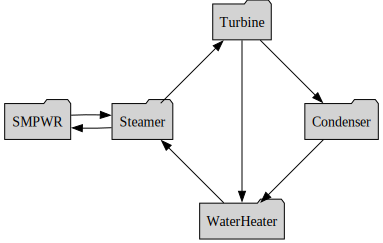

In [8]:
'''Draw network'''
plant_net.draw(engine='circo', node_shape='folder') # a directed graph means the communication is "primarily" in the arrow direction

### Comments:
+ Note general bi-directional graph connectivity
+ Note that there is no parsing of an input file to setup system.
+ `Python` programming language is used to create the configuration information directly.

## [Scalability of Assembly (Ports and Pipes)](#toc)<a id="ports"></a>
+ Ports are *cheap* to create (*i.e* little overhead) and can be created on the fly.
+ For example (assembly of droplets immersed into a vortex):

[24742] 2024-11-24 15:03:12,810 - swirl - INFO - Created Cortix object


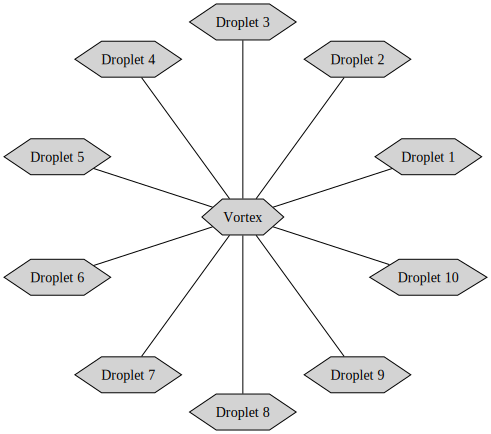

In [9]:
from cortix.examples.droplet_swirl.droplet import Droplet
from cortix.examples.droplet_swirl.vortex import Vortex

# Configuration Parameters
n_droplets = 10
log = 'swirl'
swirl = Cortix(log_filename_stem=log)
swirl.network = Network()
  
# Vortex module (single).
vortex = Vortex(log_filename_stem=log)
swirl.network.module(vortex)

for i in range(n_droplets):
# Droplet modules (multiple).
    droplet = Droplet()
    droplet.name = 'Droplet %i'%(i+1)
    swirl.network.module(droplet)
  
# Network port connectivity (connect modules through their ports)
    swirl.network.connect([droplet, 'external-flow'],
                          [vortex, vortex.get_port('fluid-flow:{}'.format(i))])
  
swirl.network.draw(engine='twopi') # an undirected graph means the communication is bidirectional

In [10]:
swirl.close()

[24742] 2024-11-24 15:03:12,967 - swirl - INFO - Closed Cortix object.
[24742] 2024-11-24 15:03:12,969 - swirl - INFO - close()::Elapsed wall clock time [s]: 0.16


### Comment
+ In cases with module repeatability the assembly process can be easily automated (as demonstrated).

## [Balance of Plant Problem Statement](#toc)<a id="problem"></a>
Develop individual [`Cortix`](https://cortix.org) modules for the sub-systems: reactor, steam generator, water heater, turbine, and a condenser. Couple the modules and evolve in time the network of sub-systems through the `Cortix` framework. Simulate a *startup* condition, continue the simulation to *steady state*, simulate a time-dependent condition for *malfunction* of the water heater sub-system, continue the simulation to the return of normal operation, and finally *shutdown* the system.

## [Module Basic Template for the Run Method](#toc)<a id="module_template"></a>

```python
class BWR(Module): # inherit from the base class Module

    def run(self, *args):
          # Module's time loop
          while time <= self.end_time:
              # Specific coding goes here (operation, on-off, status, etc.)

              # Evolve one time step
              #---------------------
              time = self.__step(time)
        
              # Communicate information
              #------------------------
              self.__call_ports(time)
                
    def __step(self, time):
        # 1. Prepare module data for ODE solver        
        # 2. Call ODE solver
        # 3. Advance time
        time += self.time_step
        # 4. Update internal state data
        return time
    
     def __call_ports(self, time):

         # Interactions in the coolant-outflow port
         #-----------------------------------------
         # One way "to" coolant-outflow
  
         # Send to
         if self.get_port('coolant-outflow').connected_port:
  
              msg_time = self.recv('coolant-outflow')

              temp = self.coolant_outflow_phase.get_value('temp', msg_time)
              press = self.coolant_outflow_phase.get_value('pressure', msg_time)
  
              coolant_outflow = dict()
              coolant_outflow['temperature'] = temp
              coolant_outflow['pressure'] = press
  
              self.send((msg_time, coolant_outflow), 'coolant-outflow')
  
          # Interactions in the coolant-inflow port
          #----------------------------------------
          # One way "from" coolant-inflow
  
          # Receive from
          if self.get_port('coolant-inflow').connected_port:
  
              self.send(time, 'coolant-inflow')
  
              inflow_coolant = self.recv('coolant-inflow')
  
              self.coolant_mass_flowrate = inflow_coolant['mass_flowrate']
              self.coolant_quality = inflow_coolant['quality']
```

## [Brief Description of BoP Modules](#toc)<a id="bop_modules"></a>

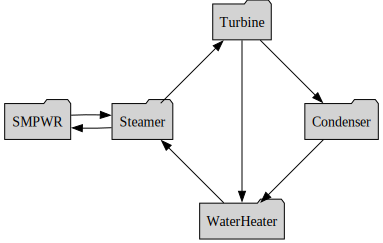

In [11]:
plant_net.draw(engine='circo', node_shape='folder') # a directed graph means the communication is "primarily" in the arrow direction

## [Pressurized Water Reactor Module](#toc)<a id="reactor"></a>
The reactor module is a single-point, two temperature model. The temperature of the core and the coolant are both solved via time dependent differential equations which makes the model able to respond to time dependent changes in the inlet or internal conditions. The reactor is also considered to be isobaric due to the usual placement of a pressurizer in real applications of PWRs. 


### [Reactor Module's Ports](#toc)<a id="port"></a>

The Reactor Module has two Ports: an Inlet port, and an Outlet port. First, the Outlet port sends information about the systems temperature, pressure, mass flowrate, and flow quality to the Steam generator's Primary inlet port.
Then, the Inlet port takes information about the temperature, pressure, mass flowrate, and flow quality from the Steam Generator's Primary Outlet port. The information from the Inlet port is then used to inform and update the information going to the Outlet port via the system of ODEs that will be discussed below. 

### [Reactor's ODE equations](#toc)<a id="eqns"></a>

The space-invariant neutron balance for the point-reactor model is,

\begin{equation*}
\frac{\text{d}n}{\text{d}t}  = \frac{\rho(t)-\beta}{\ell}\, n + \sum\limits_{i=1}^{6} \lambda_i\,c_i  + q(t),
\end{equation*}

where the first term on the right side of the equation represents the net production of neutrons not accounting for delayed neutrons (with $\rho(t)$ being the reactivity, $\beta$ being the delayed neutron fraction and $\ell$ being the prompt neutron lifetime), and the second term accounts for the source of delayed neutrons considering 6 groups of delayed neutron emitters resulting from the fission of $^{235}$U nuclei (with $\lambda$ being the decay constant of the specific delayed neutron precursor group, $c$ being its concentration and $q(t)$ being the magnitude of the neutron source, if any). Therefore a balance of neutron emitter species is also necessary.

\begin{equation*}
\frac{\text{d}c_i}{\text{d}t}  = \frac{\beta_i}{\ell}\, n - \lambda_i\,c_i ,
     \ \ \ \ \ \forall \ \ \ \ \  i=1,\ldots,6.
\end{equation*}

Where the first term on the right side of the equation is the source of emitters as a function of the neutron number density $n(t)$ (with $\beta_i$ being the yield of each delayed neutron precursor group from fission), and the second term is the consumption rate of the emitter by radioactive decay obtained as a function of the product of the number concentration of the emmiter, $c_i(t)$, multiplied by its decay constant $\lambda_i$. Here the number concentration of the $i$th emitter, $c_i$ is considered in terms of delayed neutron number density, hence the units are the same as $n$.

The current model's reactivity $\rho(t)$ considers the temperature reactivity coefficient, $\alpha_{T_n}$, that is, 

\begin{equation*}
 \rho(t) = \rho_0 + \alpha_{T_n}(T_f)\,\bigl(T_m(t) - T^{0}\bigr).
\end{equation*}

where $\rho_{0}$ is the initial reactivity insertion into the reactor, $\alpha_{T_n}$ is the overall temperature reactivity coefficient as a function of current temperature of the moderator $T_m(t)$, and $T^{0}$ is the reference temperature (298 $^{\circ}K$).

A heat balance in the static fuel dispersed into the moderator gives,

\begin{equation*}
\frac{\text{d}T_f}{\text{d}t} = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr) 
\end{equation*}

Where $T_f$ is the temperature of the fuel, $\rho_f$ and $c_{pf}$ is its density and heat capacity, $q^{'''}(t)$ is the heat generated per unit volume within the fuel, $\dot Q_f$ is the rate of heat absorption from the fuel by the moderator and $V_f$ is the total volume of the fuel. 

The rate of heat absorption by the moderator is calculated by,

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr), 
\end{equation*}

Where $U$ and $A$ are the overall heat transfer coefficient and heat transfer area, $T_f$ is the temperature of the fuel and $T_c$ is the temperature of the moderator. The UA in this equation is computed using a Nusselt correlation (Dittus-Bolter) for single phase flow. No multiphase correlation is used here because the purpose of a PWR is that the water is sufficiently pressurized such that no water ever boils in the core.

The rate of heat generation per unit volume within the fuel is equal to,

\begin{equation*}
q^{'''}(t) = G_{f}\,\sigma_\text{fo}\,N_{A}\,n(t)\,v_\text{(o)}
\end{equation*}

Where $G_f$ is the energy released per fission, $\sigma_\text{fo}$ is the microscopic fission cross section within the fuel at a reference temperature $T^\text{(o)}$ of 298 $^{\circ} K$, $N_A$ is the number density of the fuel, $n(t)$ is the neutron density at that point in time and $v_\text{(o)}$ is the velocity of a thermal neutron.

A heat balance in the flowing coolant fluid produces,

\begin{equation*}
\frac{\text{d}T_c}{\text{d}t} = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr) 
\end{equation*}

$T_c$ is the temperature of the coolant leaving the top of the reactor, $\tau_c$ is the coolant residence time within the reactor, $T_{in}$ is the temperature of the subcooled coolant entering the bottom of the reactor, $\rho_c$ is the density of the coolant, $c_{pc}$ is the heat capacity of the coolant and $V_c$ is the volume of the coolant (all properties of the coolant are calculated using the <span style="color:red">IAPWS97</span> `python` library. The heat rate source is the negative of the heat rate sink in the fuel/moderator.

The mass flowrate for this module is relaxed to steady state value, which is meant to mimic the buoyancy effects typically found in PWRs.

\begin{equation*}
\frac{dm}{dt} = \frac{\dot{m} - m_{ss}}{\ell}
\end{equation*}

Where $\dot{m}$ is the mass flowrate, $m_{ss}$ is the target mass flowrate, and $\tau$ is the residence time of the coolant mass in the reactor.

## [Steam Generator Module](#toc)<a id="steam_generator"></a>

The Steam Generator is also a single point module two temperature model; however, this module has many unique features that set it apart. The Steam Generator is where the primary and Secondary fluid flow loops interact to exchange heat. The primary loop is kept at a much higher pressure than the secondary to allow the secondary flow to boil into steam, while the primary can stay as a liquid. Both loops are maintained at a constant pressure and the flow is assumed to be counter current. While having a steam generator or any heat exchanger in counter current is the superior option for steam generation, it does provide a headache for those who wish to model them computationally. This is because you essentially need to guess the outlet conditions and solve iteratively until a solution converges.

### [Steam Generator Module's Ports](#toc)<a id="ports"></a>

The Steam Generator Module has four ports: a primary inflow, secondary inflow, primary outflow, and secondary outflow. The primary inflow port is connected to the outflow port for the reactor module and takes in the temperature, pressure, and mass flowrate of the reactor. The secondary inlet port is connected to the water heater module's outlet port and takes in the temperature, pressure, and mass flowrate of the water heater system. The primary outflow port takes the steam generator's primary loop's temperature, pressure, quality, and mass flowrate and sends it back to the reator's inlet port to be reheated. Finally, the secondary loop's outlet port sends the temperature, pressure, mass flowrate, and the total heat transfered to the turbine module for calculations and comparisons. 

### [Steam Generator's ODE equations](#toc)<a id="eqns"></a>

Compared to the reactor module, the steam generator has significantly less ODE's. The steam generator module only has two, one for the exit temperature of each loop (primary and secondary). 

\begin{equation*}
\frac{dT_{p}}{dt} = - \frac{T_{p} - T_{p,in}}{\tau_{p}} + \frac{q'''}{\rho_{p} C_{p,p}}
\end{equation*}

\begin{equation*}
\frac{dT_{s}}{dt} = - \frac{T_{s} - T_{s,in}}{\tau_{s}} - \frac{q'''}{\rho_{s} C_{p,s}} - q_{lat}
\end{equation*}

Where these equations start to get complex is finding q''' or the heat sink power density transfered between the two loops. q''' is found using the Dittus-Bolter correlation for single phase flow and Jens-Lottes correlation for two phase flow. The heat sink power density (q''') is found from,

\begin{equation*}
q''' = \frac{\dot{q}}{vol_{p}}
\end{equation*}

Where $vol_{p}$ is the volume of the primary side of the steam generator and $\dot{q}$ is the heat flux found using,

\begin{equation*}
\dot{q} = UA (T_{p,avg} - T_{s,avg})
\end{equation*}

$T_{p,avg}$ and $T_{s,avg}$ are the average between the inlet and outlet temperatures of the primary and secondary loops respectively. A is a constant and U is the overall heat transfer coefficient. 

\begin{equation*}
\frac{1}{U} = \frac{1}{h_{p}}* \frac{A_{o}}{A_{i}} + \frac{r_{o} - r_{i}}{k_{w}}*\frac{A_{o}}{A_{mean}} + f + \frac{1}{h_{s}}
\end{equation*}  

Where $h_{p}$ and $h_{s}$ are the heat transfer coefficients, $r_{i}$ and $r_{o}$ are inner and the outer radii, $A_{i}$, $A_{mean}$, and $A_{o}$ are the inner, mean, and outer heat transfer areas, and finally $k_{w}$ is the thermal conductivity of the wall. As stated earlier, $h_{p}$ is always calculated from a Dittus-Bolter correlation, while $h_{s}$ can be Dittus-Bolter or Jens-Lottes depending if there is any boiling happening on the secondary side.

---
## [Turbine Module](#toc) <a id="turbine"></a>
The Turbine module is based off an ideal or isentropic work model with a tuned efficiency term. Unlike the first two models it doesn't have an ODE system; however, it does still use the IAPWS python library to find the properties of water at several different conditions.

### [Turbine Module's ports](#toc) <a id="turb"></a>
The turbine module has three ports: an inlet port, an outlet port, and a process heat port. The inlet port takes in the temperature, pressure, mass flowrate, and total heat power $H_{SG}$ from the Steam generator's secondary outlet port. The outlet port sends the final temperature, pressure, and mass flowrate to the Condenser module's inlet port. The process heat port, unlike the other two, sends heat to the water heater module as a way to represent the energy that is normally used to power pumps and heaters. The process heat port sends the heat to the water heater's external heat port.

### [Turbine Module's Algebraic Equations](#toc) <a id="turb"></a>
While industry turbines usually have multiple stages for low, intermediate, and high pressure steam, this turbine module can be thought of as a system of turbine stages that all combine into one overall system. It is also important to note that the most energy that can be generated from a turbine is, 

\begin{equation*}
W_{ideal} = \dot{m}(h_i - h_{ideal})
\end{equation*}

Where $\dot{m}$ is the mass flowrate, $h_i$ is the inlet enthalpy, $h_{ideal}$ is based off the vent or outlet pressure of the turbine and the entropy of the inlet stream and an efficiency term was also added to get the real work later.

The Turbine module first looks at the inflow temperature and pressure to see if the inlet stream is even steam. It does this by using the IAPWS97 python library to check the dewpoint temperature at the inlet pressure. if $T_{in} < T_{sat}$ then the inflow is liquid and it "bypasses" the turbine. This means that the turbine module outputs $ T_{in} = T_{out}$, the outflow quality is 0 and the generated power is 0. If $T_{in} > T_{sat}$, then the steam is super heated and it moves on to the rest of the math.

The turbine now uses the IAPWS97 library to find a myriad of other values:
* The outlet ideal entropy $S^*_{o}$ from $T_i$ and $P_i$ using the Region2 function
* The inlet enthalpy $h_i$ from $T_i$ and $P_i$ using the Region2 function
* The bubble point entropy and enthalpy $s_b$ and $h_b$ by using $p_o$ and a quality=0 with the Region4 function
* The dew point entropy and enthalpy $s_d$ and $h_d$ by using $p_o$ and a quality=1 with the Region4 function

Next, the turbine module determines whether the ideal runoff phase is a liquid, gas, or a mixture by comparing the $s_b$, $S^*_{o}$, and $s_d$. If $S^*_{o} < s_b$ then the runoff is a liquid, if $S^*_{o} > s_d$ then the runoff is still superheated steam, and if $s_b  < S^*_{o} < s_d$ the runoff is two phase. The ideal outlet enthalpy $h^*_{o}$ is also calculated at this step either by interpolation between the dew and bubble point enthalpies or by using the Region1/Region2 functions for subcooled/superheated conditions. Now the ideal work, real work, and real outlet conditions can be calculated. Please note that the work calculated below is the specific work, and not the final work used.

\begin{equation*}
W_{ideal} = (h_i - h_{ideal})
\end{equation*}
\begin{equation*}
W_{real} = W_{ideal}\eta
\end{equation*}
\begin{equation*}
h_{o} = h_i - W_{real}
\end{equation*}

Now the real enthalpy, $h_o$, is used just like $S^*_{o}$ was used in the previous step to find the real outlet conditions such as the real outlet quality and outlet temperature.

Finally, the real turbine work and rejected work can be calculated,

\begin{equation*}
W_{T} = \dot{m}W_{real}
\end{equation*}
\begin{equation*}
W_{R} = H_{SH} - W_T 
\end{equation*}

Where $W_T$ is the turbine work generated, $W_{R}$ is the rejected heat going to the water heater, and $H_{SG}$ is the heat transfered in the steam generator.

## [Condenser Module](#toc)<a id="condenser"></a>
The condenser module is by far the simplest of all the modules and can be easily added into different systems as a template for those who may wish to expand or explore the Cortix library more. This module container has only two ports and exists to help condense any vapor that may be left over from the turbine.

### [Condenser Module's Ports](#toc)<a id="ports"></a>
The inlet port takes the in the temperature, pressure, and mass flowrate from the turbine. The outlet port takes preset values for the temperature and pressure, along with the mass flowrate from the inlet port and passes it to the water heater's inflow port. In this way the condenser controls the thermal properties of the system, while still maintaining the systems flowrate.

## [Water Heater Module](#toc)<a id="water_heater"></a>
The water heater heats up the water from the condenser to reduce the load on the steam generator. The water heater module runs of power taken from the turbine to heat the water. There is also an option to add another electric heating source, but it set to 0 for this simulation. There is a maximum power taken for the water heater and it is set at 25 MW. This is to ensure that no actual boiling occurs in this module because it is not set up to handle multiphase flow. The water heater also has the unique feature of having an accident scenario that can manipulated to turn on and off at specified times. More details about the accident scenario will be discussed later.


### [Water Heater Module's Ports](#toc)<a id="ports"></a>
This module has three ports, all of which have been talked about in previous modules but for the purpose of consistence they are: an outlet port that sends the water heaters temperature, pressure, and mass flowrate to the Steam Generator's secondary inlet port, an inlet port that takes temperature, pressure, and mass flowrate from the condenser module, and an external heat port that takes heat from the turbine's process heat port.

In the event that the previously discussed accident scenario is turned on, at the specified time, the accident scenario will activate and reduce the temperature and mass flowrate of the system to new *malfuncion* values that are sent to the steam generators secondary inlet port instead of the regular system conditions. This is meant to simulate a temporary break in the systems piping that occurs between the water heater module and the steam generator module.

### [Water Heater's ODE equations](#toc)<a id="eqns"></a>
The math in this module is not as complex as some of the other modules; however, it is still time dependent. The module has a single temperature time dependent ODE,

\begin{equation*}
\frac{dT_{h}}{dt} = - \frac{T_{h} - T_{h,in}}{\tau} + \frac{q_{turb}+q_{elec}}{V_{h}\rho_{h} C_{p,h}}
\end{equation*}

Where $T_h$ and $T_{h,in}$ are the water heaters outlet temperature and inlet temperature. $\tau$ is the residence time. $q_{turb}$ and $q_{elec}$ are the heat from the turbine and the extra electric heat that may be added in future versions of this project. And $V_{h}$, $\rho_{h}$, and $C_{p,h}$ are the volume of the water heater, density of the water in the heater, and the specific heat of the water. It should also be noted that the volume of the heater and the 25 MW limit were tuned parameters that can be further changed in necessary. 

## [Startup](#toc)<a id="startup"></a>

Here the simulation runs for a period representative of a startup interval via the following code structure:

In [12]:
'''Run BOP Network'''

from bop.support import unit

end_time = 10*unit.minute 
time_step = 1.5*unit.second
show_time = (True, 5*unit.minute)

for module in plant_net.modules:
    module.time_step = time_step
    module.end_time = end_time
    module.show_time = show_time

plant.run()   # Run network dynamics simulation
plant.close() # Close run

[24742] 2024-11-24 15:03:13,100 - cortix - INFO - Launching Module <bop.reactor.SMPWR object at 0x7fa50087ea80>
[24742] 2024-11-24 15:03:13,109 - cortix - INFO - Launching Module <bop.steamer.Steamer object at 0x7fa5000e71a0>
[24742] 2024-11-24 15:03:13,119 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7fa5038b6b10>
[24742] 2024-11-24 15:03:13,124 - cortix - INFO - Launching Module <bop.condenser.Condenser object at 0x7fa500100d70>
[24742] 2024-11-24 15:03:13,132 - cortix - INFO - Launching Module <bop.water_heater.WaterHeater object at 0x7fa5038b6ae0>
[24784] 2024-11-24 15:03:14,476 - cortix - INFO - Condenser::run():time[m]=0.0
[24781] 2024-11-24 15:03:14,683 - cortix - INFO - SMPWR::run():time[m]=0.0
[24785] 2024-11-24 15:03:14,865 - cortix - INFO - WaterHeater::run():time[m]=0.0
[24782] 2024-11-24 15:03:14,931 - cortix - INFO - Steamer::run():time[m]=0.0
[24783] 2024-11-24 15:03:14,993 - cortix - INFO - Turbine::run():time[m]=0.0
[24781] 2024-11-24 15:11:32,14

In [13]:
'''Collect multiprocessing data'''
reactor = plant_net.modules[0]
steamer = plant_net.modules[1]
turbine = plant_net.modules[2]
condenser = plant_net.modules[3]
water_heater = plant_net.modules[4]

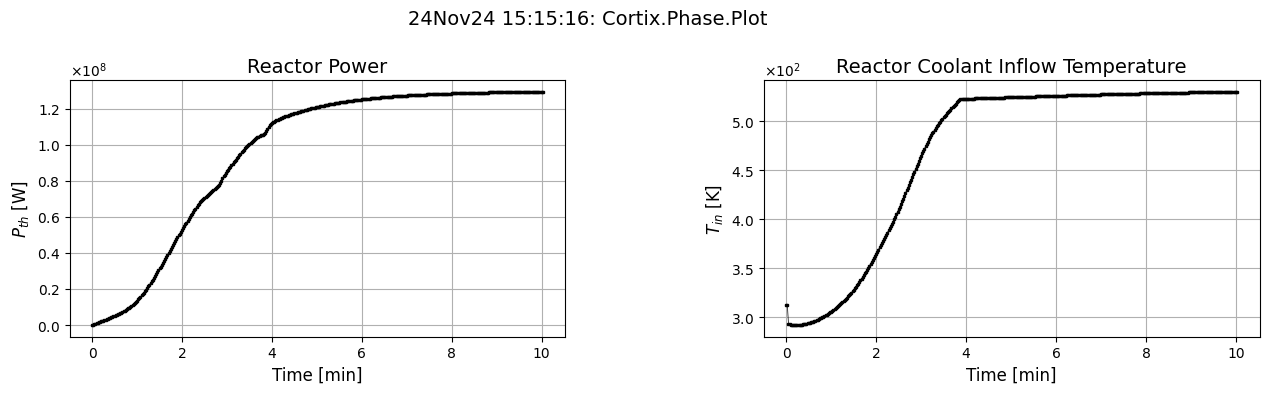

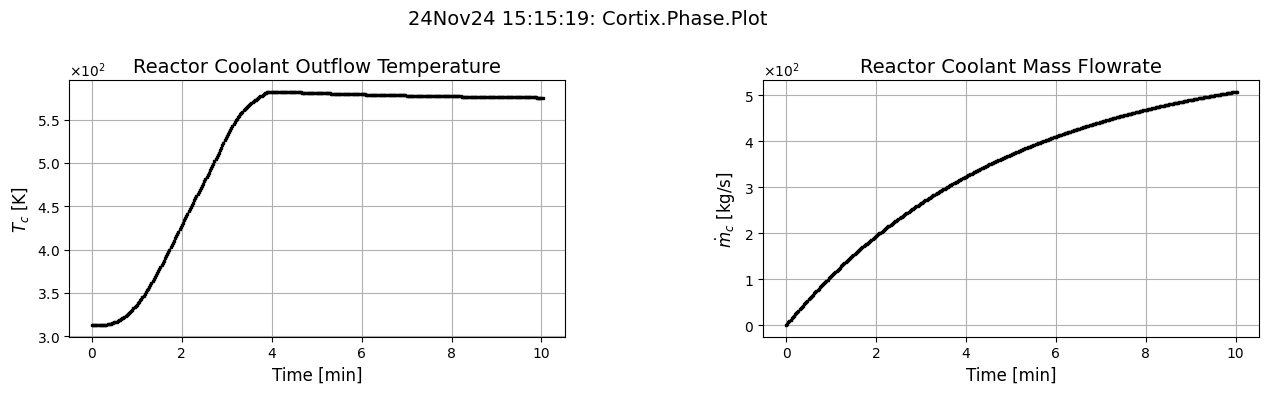

In [14]:
'''Reactor data'''
reactor.state_phase.plot(actors=['power','inlet-temp'], show=True, figsize=[14,8])
reactor.coolant_outflow_phase.plot(actors=['temp','flowrate'], show=True, figsize=[14,8])

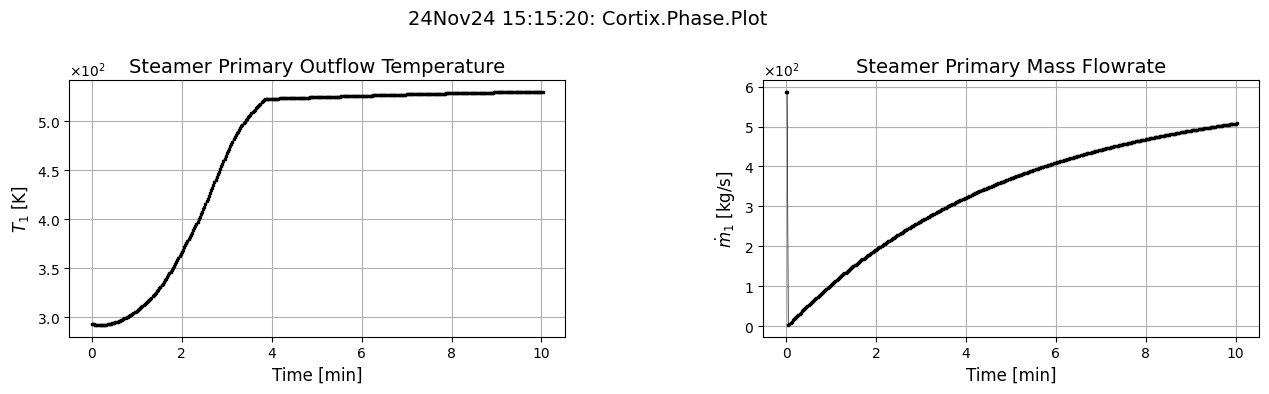

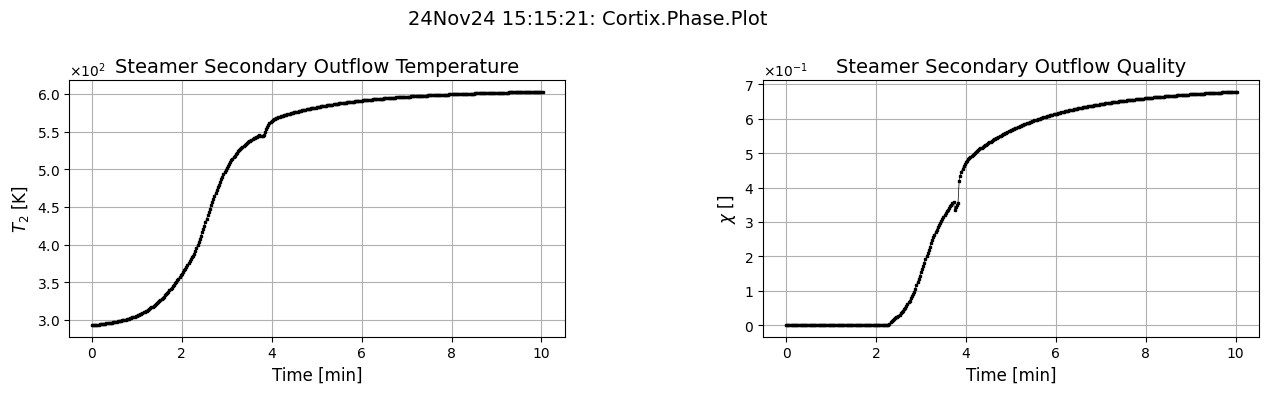

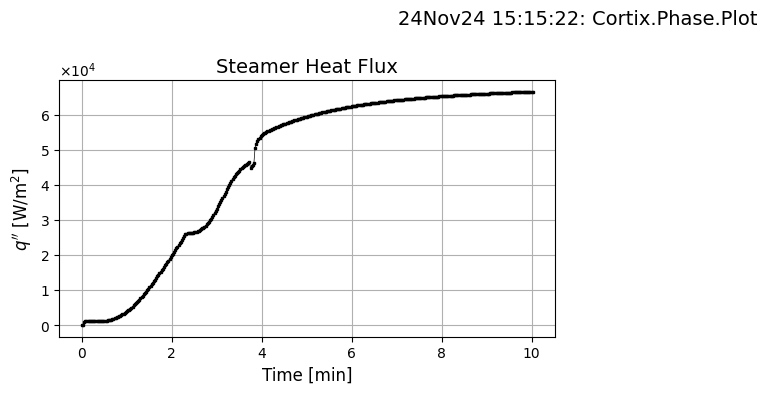

In [15]:
'''Steamer data'''
steamer.primary_outflow_phase.plot(show=True, figsize=[14,8])
steamer.secondary_outflow_phase.plot(actors=['temp','quality'], show=True, figsize=[14,8])
steamer.state_phase.plot(actors=['heatflux'], show=True, figsize=[14,8])

## [Steady State](#toc)<a id="steady_state"></a>

The previous startup simulation can be continued until a steady state is achieved as follows:

In [16]:
'''Continue simulation to steady state'''

end_time += 10*unit.minute

for module in plant_net.modules:
    module.initial_time = module.end_time
    module.end_time = end_time

# Rebuild the network since this information is lost once the Cortix object is closed
plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'])
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'])
plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'])
plant_net.connect([turbine, 'outflow'], [condenser, 'inflow'])
plant_net.connect([turbine, 'process-heat'], [water_heater, 'external-heat'])
plant_net.connect([condenser, 'outflow'], [water_heater, 'inflow'])
plant_net.connect([water_heater, 'outflow'], [steamer, 'secondary-inflow'])

In [17]:
plant.run()   # Run network dynamics simulation
plant.close() # Close run

[24742] 2024-11-24 15:15:23,503 - cortix - INFO - Launching Module <bop.reactor.SMPWR object at 0x7fa5003a19d0>
[24742] 2024-11-24 15:15:25,260 - cortix - INFO - Launching Module <bop.steamer.Steamer object at 0x7fa5003eaff0>
[25694] 2024-11-24 15:15:25,265 - cortix - INFO - SMPWR::run():time[m]=10.0
[24742] 2024-11-24 15:15:25,374 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7fa4ff834e00>
[24742] 2024-11-24 15:15:25,385 - cortix - INFO - Launching Module <bop.condenser.Condenser object at 0x7fa4ff8022d0>
[24742] 2024-11-24 15:15:25,388 - cortix - INFO - Launching Module <bop.water_heater.WaterHeater object at 0x7fa4ff837650>
[25698] 2024-11-24 15:15:27,002 - cortix - INFO - Condenser::run():time[m]=10.0
[25699] 2024-11-24 15:15:27,228 - cortix - INFO - WaterHeater::run():time[m]=10.0
[25697] 2024-11-24 15:15:27,257 - cortix - INFO - Turbine::run():time[m]=10.0
[25695] 2024-11-24 15:15:27,262 - cortix - INFO - Steamer::run():time[m]=10.0
[25694] 2024-11-24 15:18:

In [18]:
'''Collect multiprocessing data'''
reactor = plant_net.modules[0]
steamer = plant_net.modules[1]
turbine = plant_net.modules[2]
condenser = plant_net.modules[3]
water_heater = plant_net.modules[4]

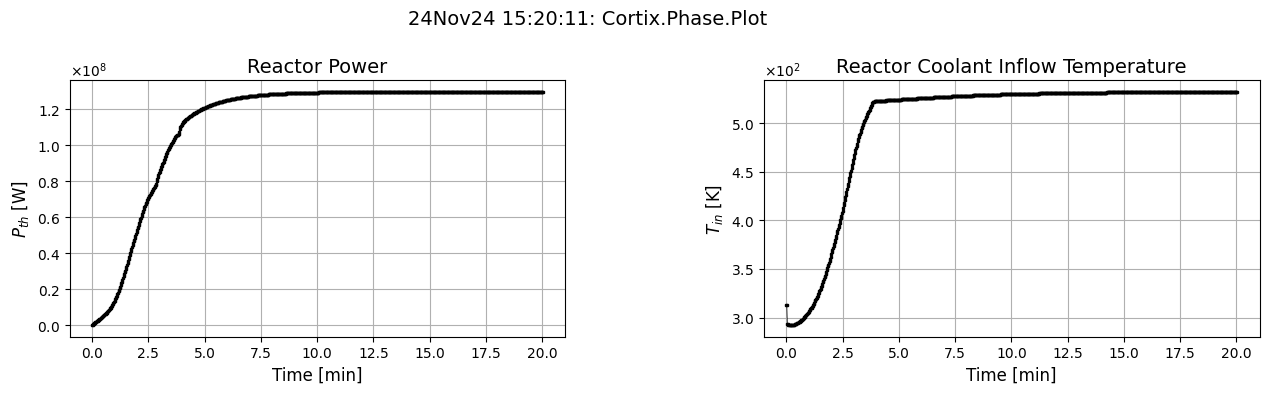

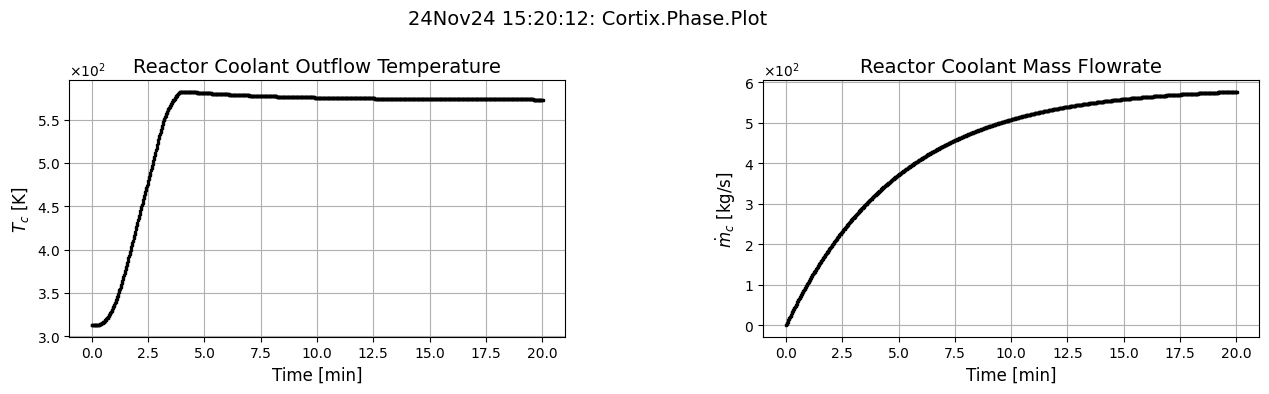

In [19]:
'''Reactor data'''
reactor.state_phase.plot(actors=['power','inlet-temp'], show=True, figsize=[14,8])
reactor.coolant_outflow_phase.plot(actors=['temp','flowrate'], show=True, figsize=[14,8])

## [Water Heater Malfunction](#toc)<a id="malfunction"></a>

Continuing the simulation from the steady state above, a malfunction is created by interrupting the line from the water heater module to the steamer module for a given interval of time; normal conditions resume when the interruption ends. This scenario's program follows:

In [20]:
'''Continue simulation with malfunction of water heater'''

end_time += 25*unit.minute

for module in plant_net.modules:
    module.initial_time = module.end_time
    module.end_time = end_time
    
plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'])
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'])
plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'])
plant_net.connect([turbine, 'outflow'], [condenser, 'inflow'])
plant_net.connect([turbine, 'process-heat'], [water_heater, 'external-heat'])
plant_net.connect([condenser, 'outflow'], [water_heater, 'inflow'])
plant_net.connect([water_heater, 'outflow'], [steamer, 'secondary-inflow'])

In [21]:
initial_malfunction_time = water_heater.initial_time + 5*unit.minute
final_malfunction_time = initial_malfunction_time + 15*unit.minute

water_heater.malfunction = (True, initial_malfunction_time, final_malfunction_time)

plant.run()   # Run network dynamics simulation
plant.close() # Close run

[24742] 2024-11-24 15:20:13,721 - cortix - INFO - Launching Module <bop.reactor.SMPWR object at 0x7fa4fa8d90d0>
[24742] 2024-11-24 15:20:15,603 - cortix - INFO - Launching Module <bop.steamer.Steamer object at 0x7fa5038b6ae0>
[25992] 2024-11-24 15:20:15,611 - cortix - INFO - SMPWR::run():time[m]=20.0
[24742] 2024-11-24 15:20:17,503 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7fa4fab743b0>
[25994] 2024-11-24 15:20:17,509 - cortix - INFO - Steamer::run():time[m]=20.0
[24742] 2024-11-24 15:20:17,599 - cortix - INFO - Launching Module <bop.condenser.Condenser object at 0x7fa4facd7f80>
[24742] 2024-11-24 15:20:17,616 - cortix - INFO - Launching Module <bop.water_heater.WaterHeater object at 0x7fa4fad23260>
[25997] 2024-11-24 15:20:19,239 - cortix - INFO - Condenser::run():time[m]=20.0
[25996] 2024-11-24 15:20:19,350 - cortix - INFO - Turbine::run():time[m]=20.0
[25998] 2024-11-24 15:20:19,431 - cortix - INFO - WaterHeater::run():time[m]=20.0
[25992] 2024-11-24 15:21:

In [22]:
'''Collect multiprocessing data'''
reactor = plant_net.modules[0]
steamer = plant_net.modules[1]
turbine = plant_net.modules[2]
condenser = plant_net.modules[3]
water_heater = plant_net.modules[4]

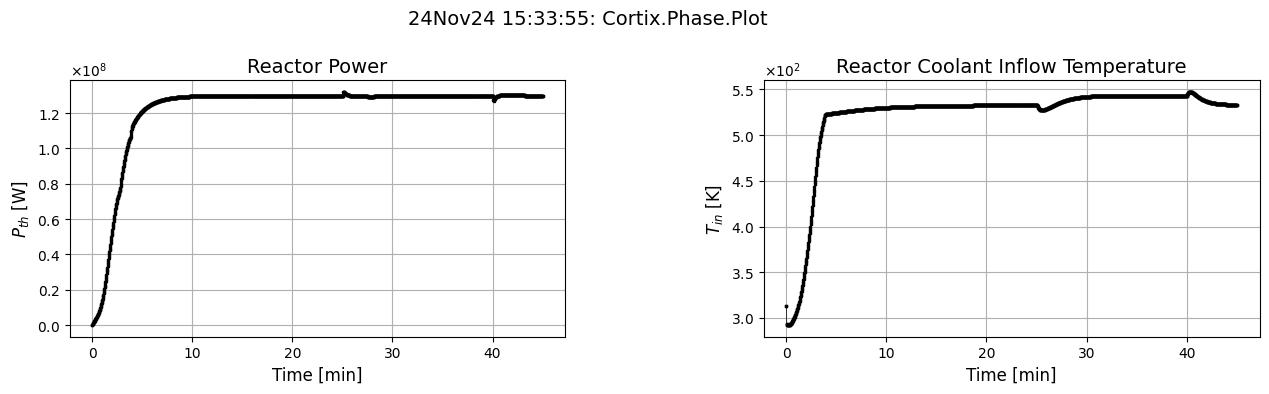

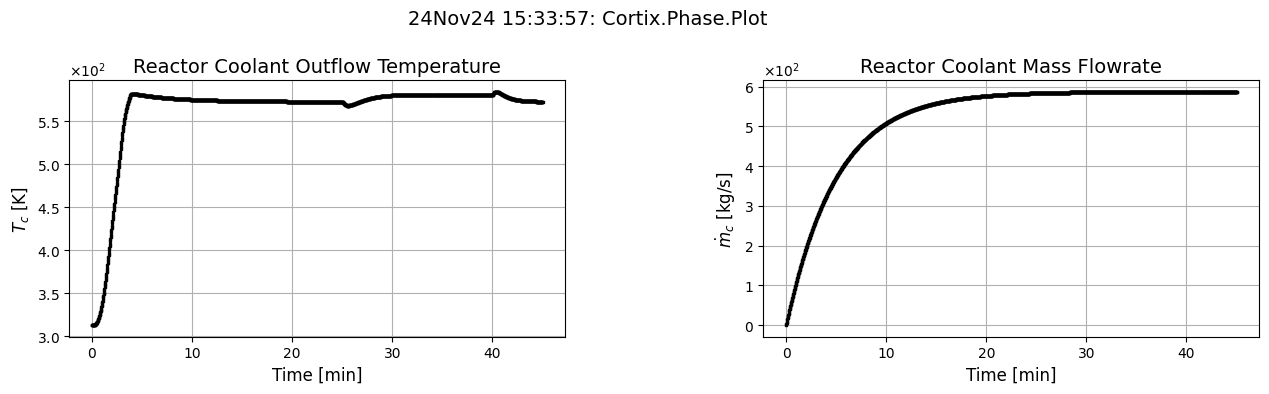

In [23]:
'''Reactor data'''
reactor.state_phase.plot(actors=['power','inlet-temp'], show=True,figsize=[14,8])
reactor.coolant_outflow_phase.plot(actors=['temp','flowrate'], show=True,figsize=[14,8])

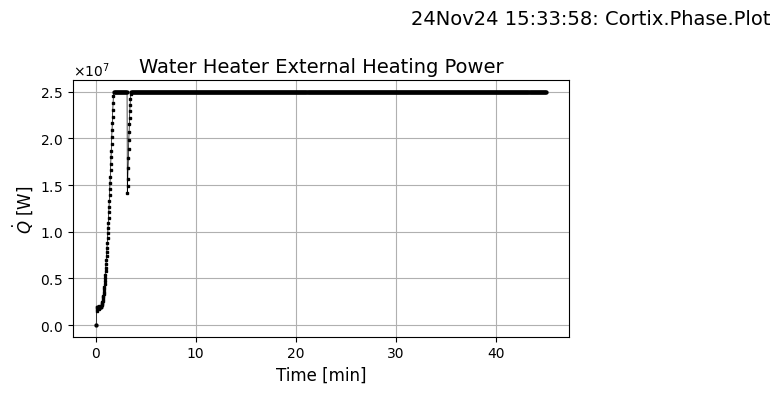

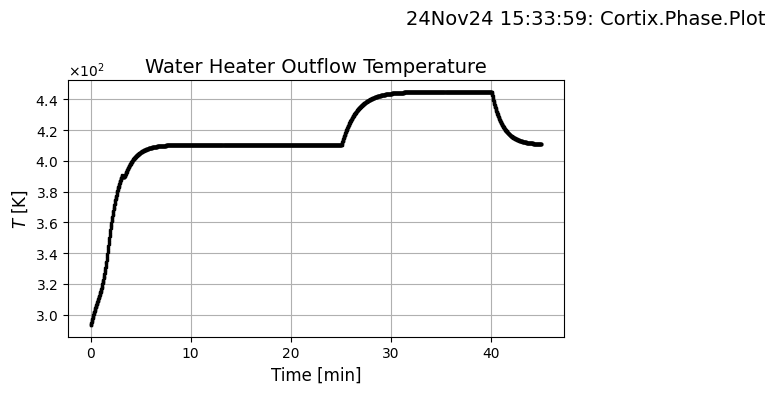

In [24]:
'''Water heater data'''
water_heater.inflow_phase.plot(actors=['external-heat'], show=True,figsize=[14,8])
water_heater.outflow_phase.plot(actors=['temp'], show=True,figsize=[14,8])

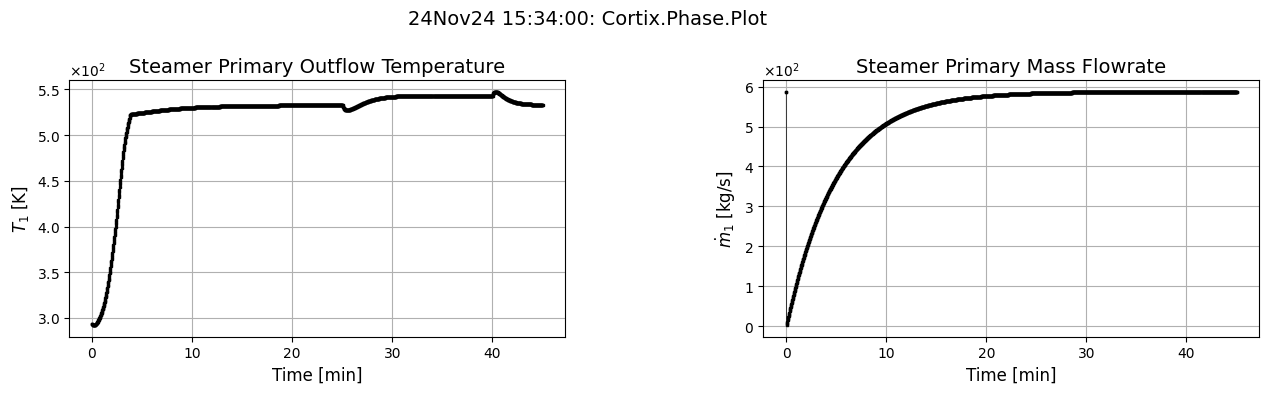

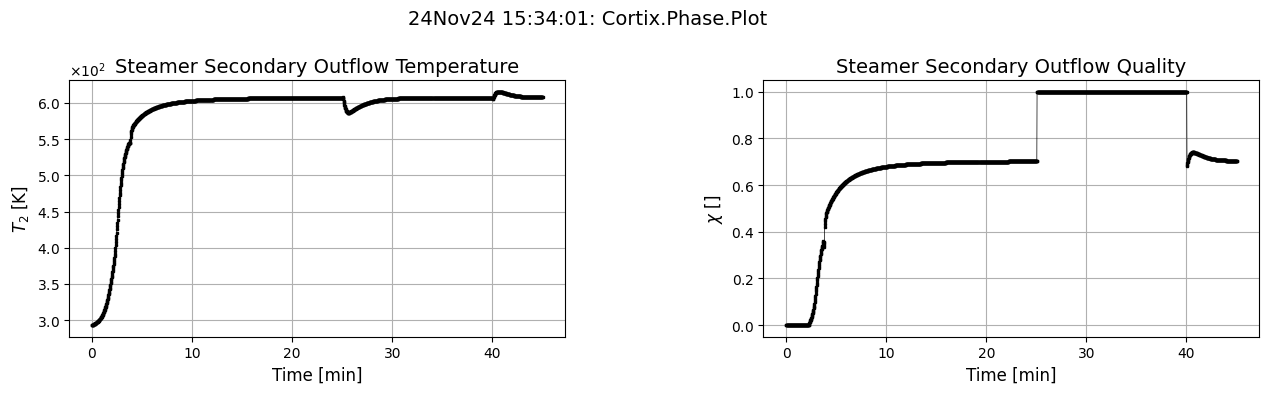

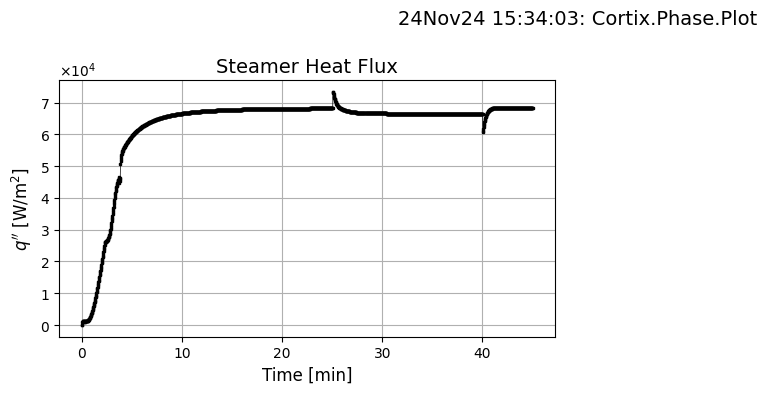

In [25]:
'''Steamer data'''
steamer.primary_outflow_phase.plot(show=True, figsize=[14,8])
steamer.secondary_outflow_phase.plot(actors=['temp','quality'], show=True, figsize=[14,8])
steamer.state_phase.plot(actors=['heatflux'], show=True, figsize=[14,8])

## [Shutdown](#toc)<a id="shutdown"></a>
Finally, continuing the simulation from the normal conditions after the foregoing malfunction, the simulation is set to shutdown the plant:

In [26]:
'''Continue simulation with malfunction of water heater'''

end_time += 15*unit.minute

for module in plant_net.modules:
    module.initial_time = module.end_time
    module.end_time = end_time
    
plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'])
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'])
plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'])
plant_net.connect([turbine, 'outflow'], [condenser, 'inflow'])
plant_net.connect([turbine, 'process-heat'], [water_heater, 'external-heat'])
plant_net.connect([condenser, 'outflow'], [water_heater, 'inflow'])
plant_net.connect([water_heater, 'outflow'], [steamer, 'secondary-inflow'])

In [27]:
shutdown_time = reactor.initial_time + 5*unit.minute

reactor.shutdown = (True, shutdown_time)

plant.run()   # Run network dynamics simulation
plant.close() # Close run

[24742] 2024-11-24 15:34:04,079 - cortix - INFO - Launching Module <bop.reactor.SMPWR object at 0x7fa5000e52e0>
[24742] 2024-11-24 15:34:05,987 - cortix - INFO - Launching Module <bop.steamer.Steamer object at 0x7fa50101ede0>
[26914] 2024-11-24 15:34:05,995 - cortix - INFO - SMPWR::run():time[m]=45.0
[24742] 2024-11-24 15:34:07,836 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7fa5038b6630>
[26916] 2024-11-24 15:34:07,843 - cortix - INFO - Steamer::run():time[m]=45.0
[24742] 2024-11-24 15:34:09,529 - cortix - INFO - Launching Module <bop.condenser.Condenser object at 0x7fa4fa622a20>
[26920] 2024-11-24 15:34:09,534 - cortix - INFO - Turbine::run():time[m]=45.0
[24742] 2024-11-24 15:34:09,608 - cortix - INFO - Launching Module <bop.water_heater.WaterHeater object at 0x7fa4faaa8260>
[26923] 2024-11-24 15:34:11,047 - cortix - INFO - Condenser::run():time[m]=45.0
[26924] 2024-11-24 15:34:11,288 - cortix - INFO - WaterHeater::run():time[m]=45.0
[26914] 2024-11-24 15:36:

In [28]:
'''Collect multiprocessing data'''

reactor = plant_net.modules[0]
steamer = plant_net.modules[1]
turbine = plant_net.modules[2]
condenser = plant_net.modules[3]
water_heater = plant_net.modules[4]

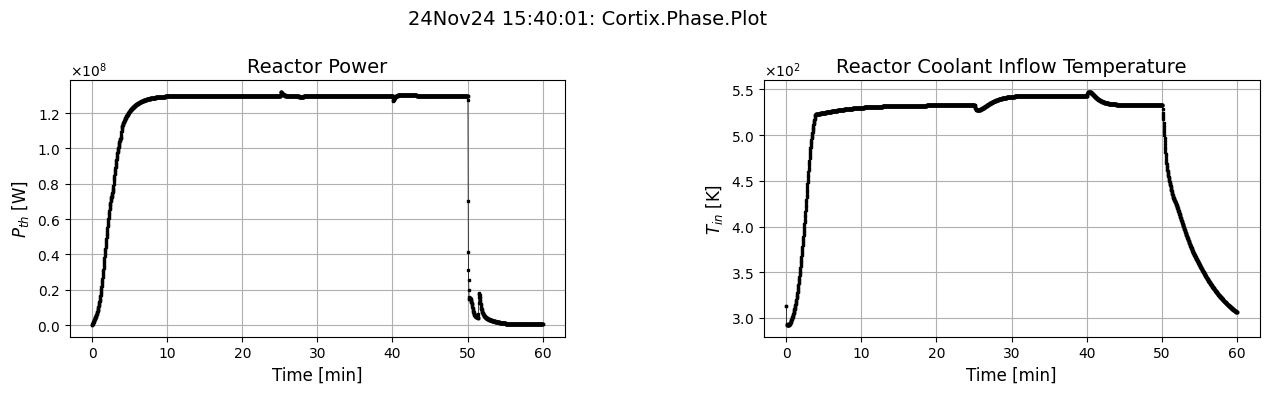

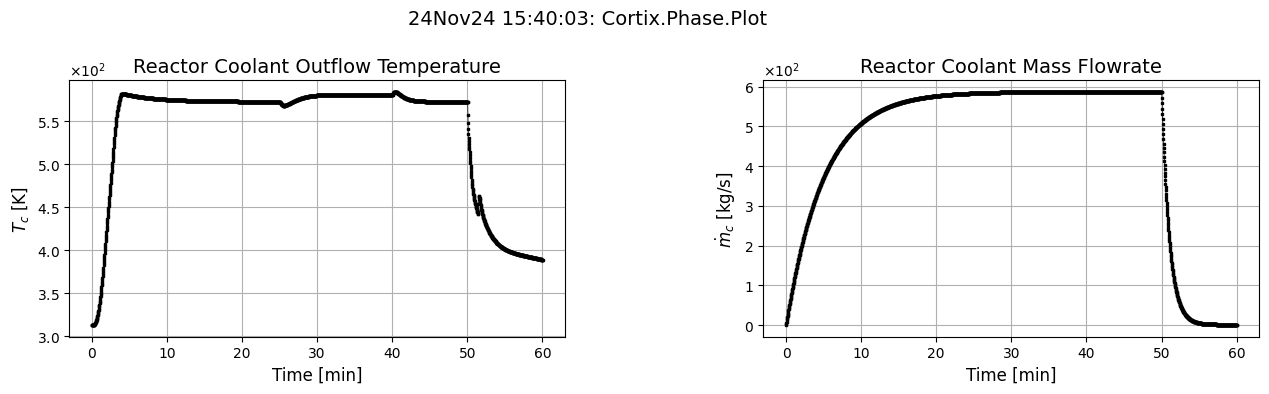

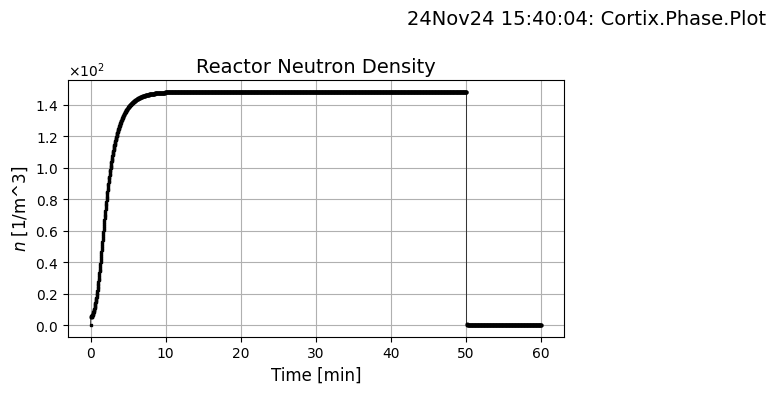

In [29]:
'''Reactor data'''
reactor.state_phase.plot(actors=['power','inlet-temp'], show=True,figsize=[14,8])
reactor.coolant_outflow_phase.plot(actors=['temp','flowrate'], show=True,figsize=[14,8])
reactor.neutron_phase.plot(actors=['neutron-dens'], show=True, figsize=[14,8])

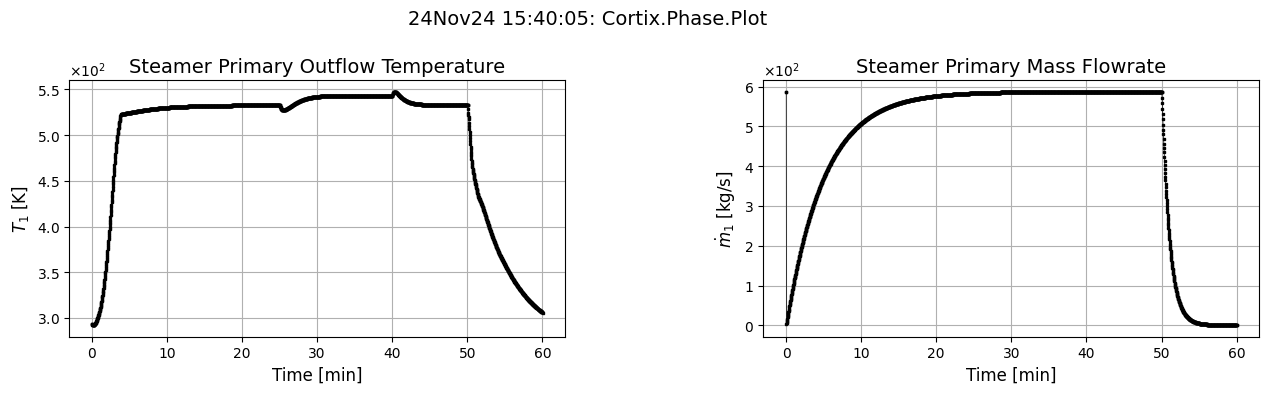

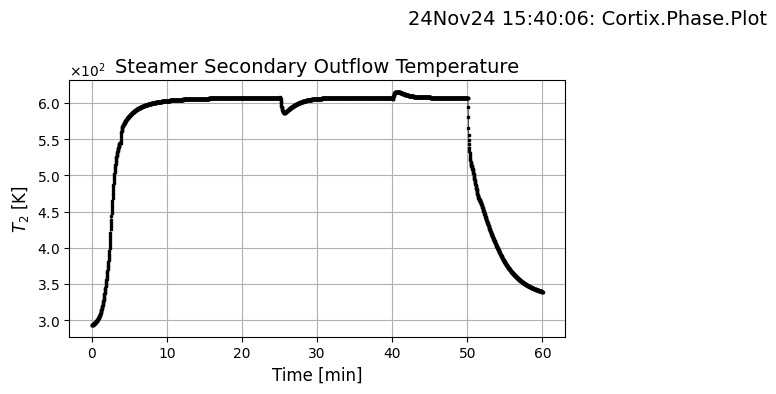

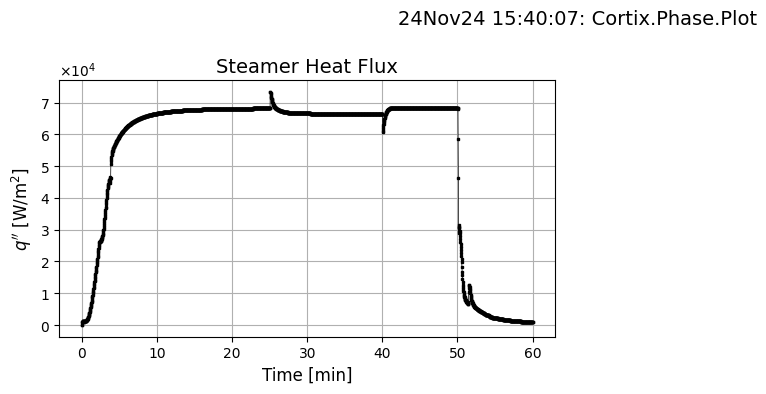

In [30]:
'''Steamer data'''
steamer.primary_outflow_phase.plot(show=True, figsize=[14,8])
steamer.secondary_outflow_phase.plot(actors=['temp'], show=True, figsize=[14,8])
steamer.state_phase.plot(actors=['heatflux'], show=True, figsize=[14,8])

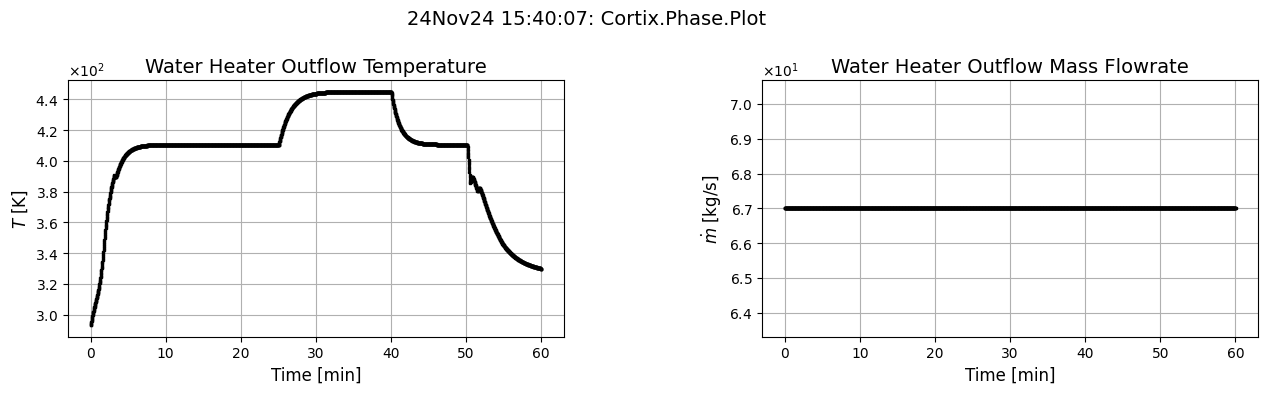

In [31]:
'''Water heater data'''
water_heater.outflow_phase.plot(actors=['temp','flowrate'], show=True,figsize=[14,8])

## [Final Comments](#toc)<a id="final_comments"></a>

+ System-level models can be coupled and assembled into a dynamic network using `Cortix` and the Python ecosystem.
+ Using message passing and parallel processing supported by `Cortix`, a simulation can be executed in various computing platforms including high-performance computers.
+ Full integration to Jupyter notebooks accelerates collaboration and programming.


### Thank you for stopping by.

## [Acknowledgements](#toc)<a id="ackn"></a>

This work was partially funded by the [Francis College of Engineering at UMass Lowell](https://www.uml.edu/engineering/), Department of Chemical Engineering (Nuclear Program), and the [Cortix](https://cortix.org) group.

## [References](#toc)<a id="refs"></a>

- [1] J. Kennedy, N. Kemper, V. F. de Almeida, [Engy-4390: Small Modular Pressurized Water Reactor](https://github.com/dpploy/engy-4390/tree/main/projects/sm-pwr).
- [2] Dale Atkinson, “NuScale update for NASEO” Nuscale power, May 2019. Retrieved at:https://naseo.org/Data/Sites/1/atkinson_naseo-may-22,-2019.pdf 
- [3] V. F. de Almeida, [Cortix](https://cortix.org), *Network Dynamics Simulation*, University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear program).
- [4] V. F. de Almeida, [*Engy-4350: Nuclear Reactor Engineering*](https://github.com/dpploy/engy-4350), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Program).
- [5] NuScale, "NuScale Standard PlantDesign Certification Application, Chapter Four, Reactor, Revision 5", July 2020.Retrieved at:https://www.nrc.gov/docs/ML2022/ML20224A492.pdf
- [6] NuScale, "NuScale Standard PlantDesign Certification Application, Chapter Five, Reactor Coolant Systems and Connecting Systems, Revision 5", July 2020.Retrieved at:https://www.nrc.gov/docs/ML2022/ML20224A493.pdf
- [7] NuScale, "NuScale Standard PlantDesign Certification Application, Chapter Ten, Steam and Power Conversion System, Revision 5", July 2020.Retrieved at:https://www.nrc.gov/docs/ML2022/ML20224A499.pdf